In [1]:
# Programa de ejemplo de lectura de datos y aplicación de bias correction para un seminario introductorio a BC
# Ana Casanueva, 20.03.24
rm(list=ls())
graphics.off()
library(loadeR) # para leer datos (función loadGridData)
library(visualizeR) # para generar figuras (función spatialPlot)
library(downscaleR) # para bias correction (función biasCorrection)
library(transformeR) # para transformaciones, p.ej. subset (subsetDimension, subsetGrid), interpolar (interpGrid), etc.
library(climate4R.indices) # para calcular índices

Warning message:
"package 'loadeR' was built under R version 3.6.3"Loading required package: rJava
Warning message:
"package 'rJava' was built under R version 3.6.3"Loading required package: loadeR.java
Warning message:
"package 'loadeR.java' was built under R version 3.6.3"Java version 21x amd64 by Azul Systems, Inc. detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
Loading required package: climate4R.UDG
Warning message:
"package 'climate4R.UDG' was built under R version 3.6.3"climate4R.UDG version 0.2.6 (2023-06-26) is loaded
Please use 'citation("climate4R.UDG")' to cite this package.
loadeR version 1.8.1 (2023-06-22) is loaded
Please use 'citation("loadeR")' to cite this package.
Warning message:
"package 'visualizeR' was built under R version 3.6.3"Loading required package: transformeR
Warning message:
"package 'transformeR' was built under R version 3.6.3"


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded
Please see 'citation("transformeR")' to cite this package.
visualizeR version 1.6.4 (2023-10-26) is loaded
Please see 'citation("visualizeR")' to cite this package.
Warning message:
"package 'downscaleR' was built under R version 3.6.3"downscaleR version 3.3.4 (2023-06-22) is loaded
Please use 'citation("downscaleR")' to cite this package.
Warning message:
"package 'climate4R.indices' was built under R version 3.6.3"climate4R.indices version 0.3.1 (2023-06-22) is loaded
Use 'indexShow()' for an overview of the available climate indices and circIndexShow() for the circulation indices.
NOTE: use package climate4R.climdex to calculate ETCCDI indices.

Attaching package: 'climate4R.indices'

The following object is masked from 'package:transformeR':

    lambWT



In [ ]:
conda create -n climate4R -c conda-forge r-climate4R
# version 4.3.1

In [2]:
# Leer el archivo CSV
df <- read.csv("../inventory.csv")

# Filtrar los enlaces que necesitas
sub <- subset(df, product == 'AEMET-5KM-regular')
obs.url <- as.character(sub$location)

# Ejecutar dataInventory con los enlaces filtrados
di <- dataInventory(obs.url)

[2024-04-08 10:30:41] Doing inventory ...
[2024-04-08 10:30:41] Opening dataset...
[2024-04-08 10:30:46] The dataset was successfuly opened
[2024-04-08 10:30:48] Retrieving info for 'pr' (2 vars remaining)
[2024-04-08 10:30:48] Retrieving info for 'tasmax' (1 vars remaining)
[2024-04-08 10:30:48] Retrieving info for 'tasmin' (0 vars remaining)
[2024-04-08 10:30:49] Done.


In [3]:
pr1  <- readRDS("../aemet/pr51_61.rds")
pr2 <- readRDS("../aemet/pr62_72.rds")
tmax1 <- readRDS("../aemet/tmax51_61.rds")
tmax2 <- readRDS("../aemet/tmax62_72.rds")

In [4]:
pr <- bindGrid(pr1, pr2, dimension="time")
tmax <- bindGrid(tmax1, tmax2, dimension="time")

[2024-04-08 10:41:46] - Computing climatology...
[2024-04-08 10:41:57] - Done.


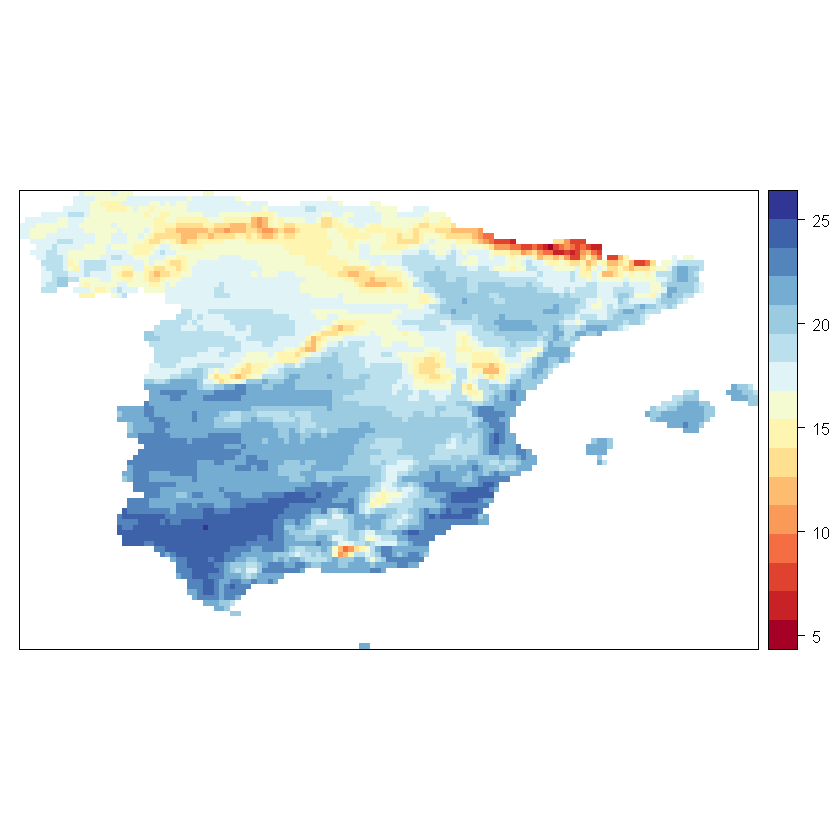

In [6]:
spatialPlot(climatology(tmax))

[2024-04-08 10:44:23] - Computing climatology...
[2024-04-08 10:44:30] - Done.


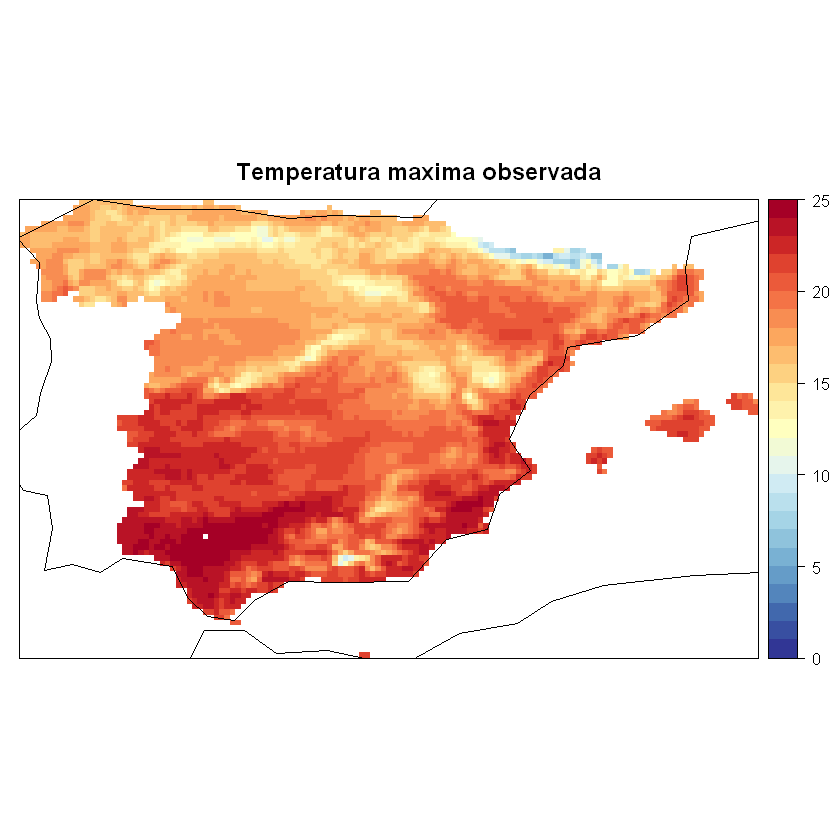

In [8]:
spatialPlot(climatology(tmax), backdrop.theme = "coastline", rev.colors = TRUE, at= seq(0,25), 
            main= "Temperatura maxima observada")


In [9]:
#########################
# *** Leer un modelo ****
#########################
rcm.hist.subset <- subset(df, activity == 'CORDEX' & domain=='EUR-44' & experiment == 'historical' & variable=='tasmax' & rcm =='RACMO22E' & model == 'ICHEC-EC-EARTH' & ensemble == 'r1i1p1') 
rcm.hist.loc <- as.character(rcm.hist.subset $location)
hist.data <- loadGridData(rcm.hist.loc, var="tasmax", years= 1951:1972,lonLim =c(-10, 5), latLim = c(35,44))
# Comprobar las unidades de los datos
message("model units ",getGridUnits(hist.data)) # degC para temperaturas, mm ó kg*m-2 para precipitación
# Pasar a grados Celsius
hist.data <- gridArithmetics(hist.data, 273.15, operator="-")

[2024-04-08 10:49:24] Opening dataset...
[2024-04-08 10:49:28] The dataset was successfuly opened
[2024-04-08 10:49:28] Defining geo-location parameters
[2024-04-08 10:49:29] Defining time selection parameters
[2024-04-08 10:49:29] Retrieving data subset ...
[2024-04-08 10:49:59] Done
model units K


[2024-04-08 10:50:14] - Computing climatology...
[2024-04-08 10:50:14] - Done.


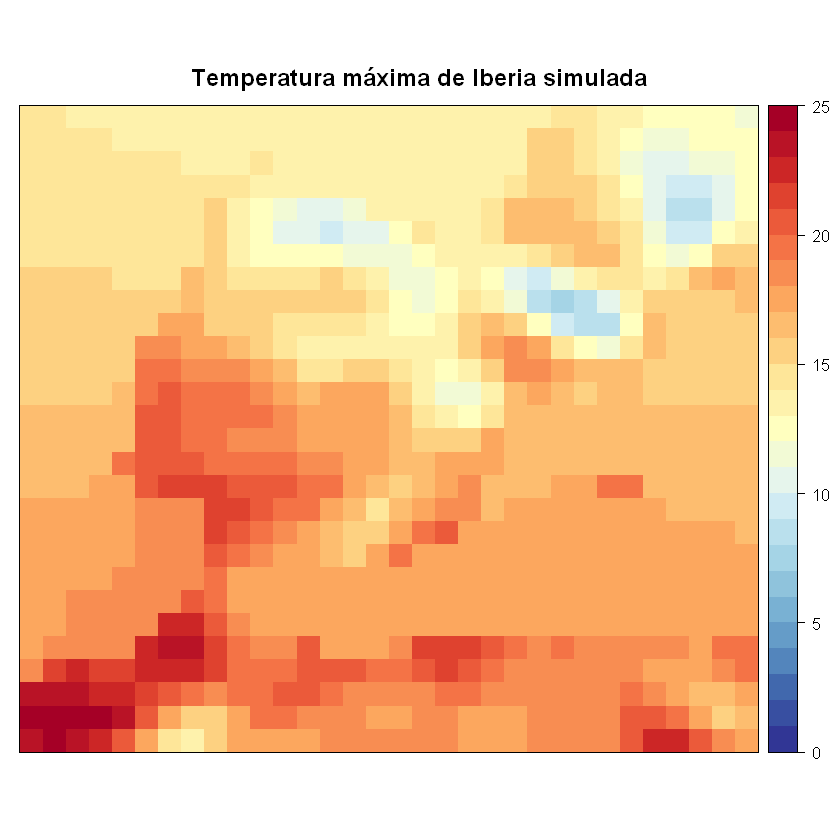

In [10]:
spatialPlot(climatology(hist.data) , backdrop.theme = "coastline", rev.colors = TRUE,  at= seq(0,25),
            main= "Temperatura máxima de Iberia simulada") # lo pinta en el Ecuador, donde está centrada la malla regular del modelo

In [11]:
##############################################
# *** Aplicar máscara de tierra al modelo ****
##############################################
rcm.mask <- subset(df, activity == 'CORDEX' & domain=='EUR-44' & experiment == 'historical' & variable=='sftlf' & rcm =='RACMO22E' & model == 'ICHEC-EC-EARTH' & ensemble == 'r1i1p1') 
rcm.mask.loc <- as.character(rcm.mask$location)
rcm.mask <- loadGridData(rcm.mask.loc, var="sftlf", lonLim =c(-10, 5), latLim = c(35,44))
# En este modelo, valores entre 0 y 100 de land area fraction, establecemos un umbral para decir qué es tierra y qué es mar

[2024-04-08 10:51:04] Opening dataset...
[2024-04-08 10:51:05] The dataset was successfuly opened
[2024-04-08 10:51:05] Defining geo-location parameters
[2024-04-08 10:51:05] Defining time selection parameters
NOTE: Undefined Dataset Time Axis (static variable)
[2024-04-08 10:51:05] Retrieving data subset ...
[2024-04-08 10:51:06] Done


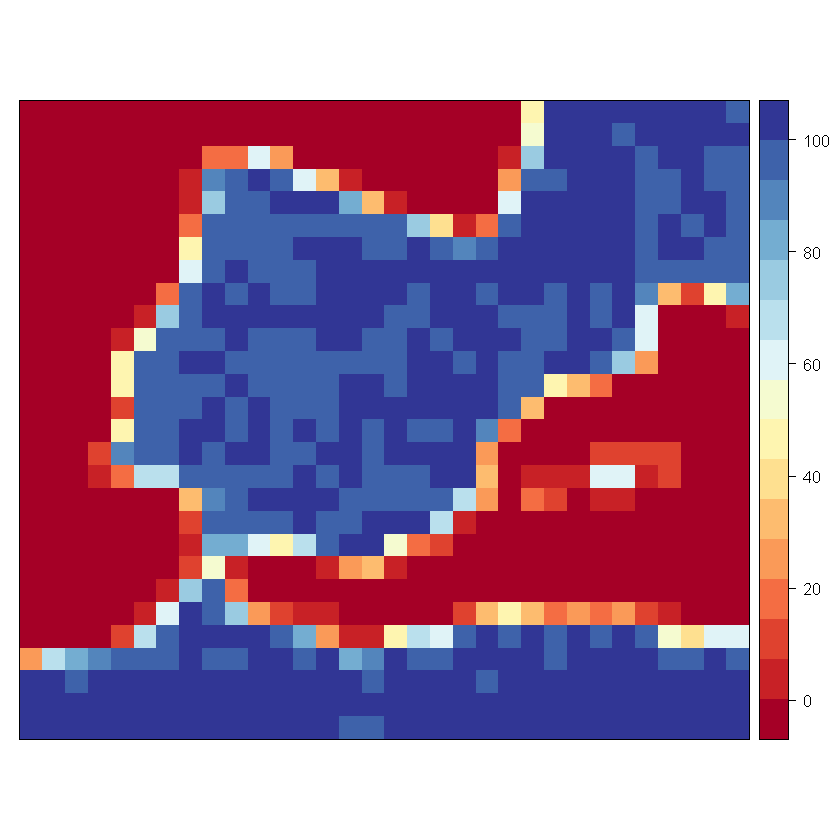

In [12]:
spatialPlot(rcm.mask) # porcentaje de tierra de cada pixel

In [13]:
rcm.mask$Data[rcm.mask$Data < 40] <- NA
rcm.mask$Data[rcm.mask$Data >= 40] <- 1 # OJO! puede que en el algún modelo venga en tanto por 1 en lugar de %. Adaptar.

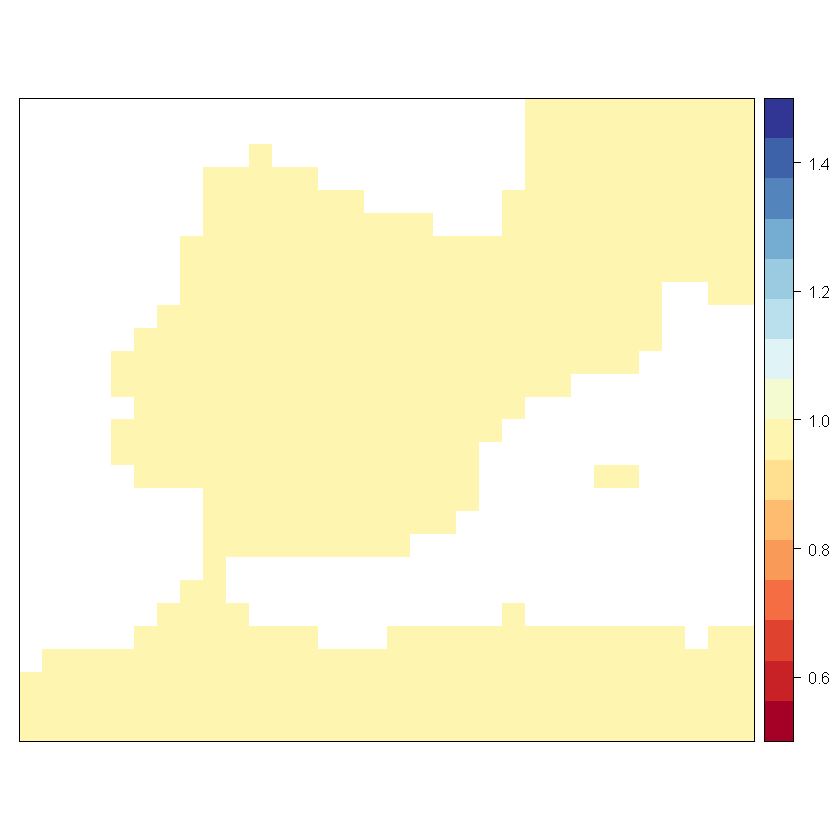

In [14]:
spatialPlot(rcm.mask) # 1's en tierra, NA's en mar

In [15]:
# Multiplicamos los datos del modelo por su máscara tierra-mar. Pondrá NA en los puntos de mar.
# Se hace una multiplicación día a día de los datos del modelo por la máscara.
time <- getRefDates(hist.data)
nt <- length(time)
ls <-lapply(1:nt, function(i){
  timei <-subsetDimension(hist.data, dimension = "time", indices=i) # separa día a día 
  gridArithmetics(timei, rcm.mask, operator = "*") # multiplica los dos grids
}
)
rcm.hist.masked <- bindGrid(ls, dimension = "time") # bindGrid es una función de transforeR que vuelve a unir todos los días en un grid de climate4R
rm(hist.data, ls, rcm.mask)

[2024-04-08 10:55:08] - Computing climatology...
[2024-04-08 10:55:10] - Done.


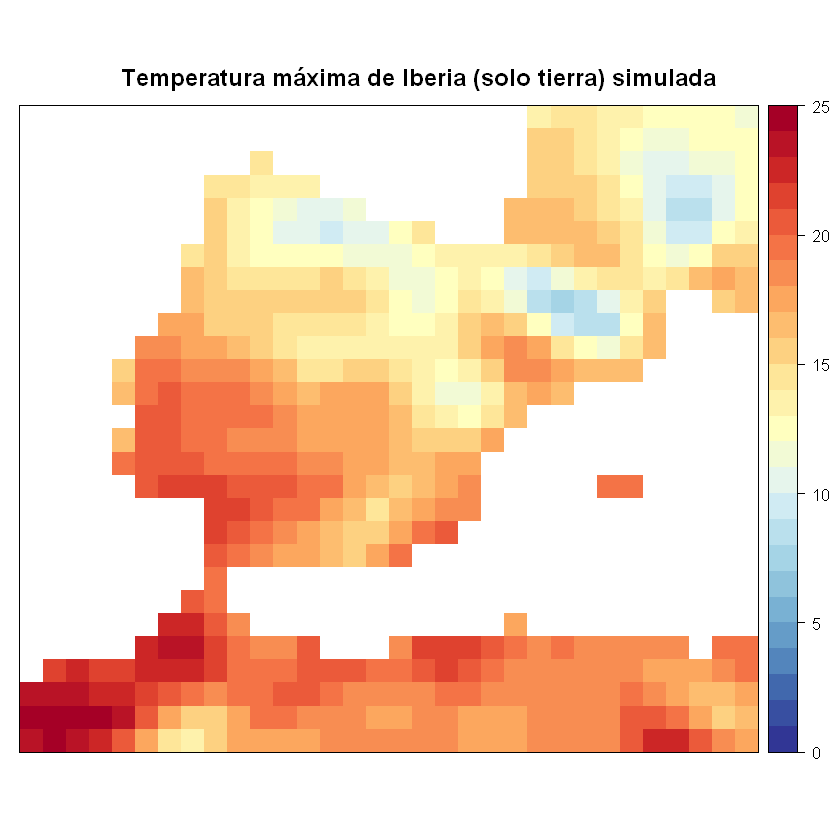

In [16]:
spatialPlot(climatology(rcm.hist.masked) , backdrop.theme = "coastline", rev.colors = TRUE,  
            at= seq(0,25), main= "Temperatura máxima de Iberia (solo tierra) simulada")# lo pinta en el Ecuador, donde está centrada la malla regular del modelo

In [19]:
############################################################
# *** Interpolar el modelo a la malla de la observación ****
############################################################
# Este paso lo hace automáticamente biasCorrection, pero lo hago aquí para representar el modelo en la misma malla que la observación y calcular el sesgo (bias)
rcm.hist.interp <- interpGrid(rcm.hist.masked, new.coordinates = getGrid(tmax))

[2024-04-08 11:05:47] Calculating nearest neighbors...
[2024-04-08 11:05:49] Performing nearest interpolation... may take a while


In [18]:
spatialPlot(makeMultiGrid(climatology(tmax),climatology(rcm.hist.interp)) , backdrop.theme = "coastline", 
            rev.colors = TRUE,  at= seq(0,25), main= "Temperatura máxima en Iberia", as.table=TRUE, 
            names.attr=c("OBS", "RCM interpolado"), layout=c(2,1)) # pinta ambos en las latitudes que tocan

[2024-04-08 11:04:53] - Computing climatology...
[2024-04-08 11:05:23] - Done.


ERROR: Error in getDim(grid): objeto 'rcm.hist.interp' no encontrado


Pruebas 29/04/29


In [2]:
pr.fut <- readRDS("EUR-11/rcp85_interpolado_pr_EUR-11_71_100.rds")

In [3]:
sesgo <- readRDS("EUR-11/sesgo_pr_EUR-11_scaling.rds")

In [15]:
prueba <- readRDS("prueba.rds")

In [16]:
str(prueba)

List of 4
 $ Variable:List of 2
  ..$ varName: chr "pr"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi FALSE
  ..- attr(*, "description")= chr "Precipitation"
  ..- attr(*, "units")= chr "kg m-2 s-1"
  ..- attr(*, "longname")= chr "pr"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "none"
  ..- attr(*, "subset")= chr "time"
 $ Data    : num [1:10957, 1:85, 1:137] NA NA NA NA NA NA NA NA NA NA ...
  ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
 $ xyCoords:List of 2
  ..$ x: num [1:137] -9.3 -9.2 -9.1 -9 -8.9 ...
  ..$ y: num [1:85] 35.3 35.4 35.5 35.6 35.7 ...
  ..- attr(*, "resX")= num 0.1
  ..- attr(*, "resY")= num 0.1
  ..- attr(*, "projection")= chr "LatLonProjection"
  ..- attr(*, "interpolation")= chr "nearest"
 $ Dates   :List of 2
  ..$ start: chr [1:10957] "2041-01-01 12:00:00 GMT" "2041-01-02 12:00:00 GMT" "2041-01-03 12:00:00 GMT" "2041-01-04 12:00:00 GMT" ...
  ..$ 

In [17]:
print(prueba$Data)

, , 1

         [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13]
    [1,]   NA   NA   NA   NA   NA   NA   NA   NA   NA    NA    NA    NA    NA
    [2,]   NA   NA   NA   NA   NA   NA   NA   NA   NA    NA    NA    NA    NA
    [3,]   NA   NA   NA   NA   NA   NA   NA   NA   NA    NA    NA    NA    NA
    [4,]   NA   NA   NA   NA   NA   NA   NA   NA   NA    NA    NA    NA    NA
    [5,]   NA   NA   NA   NA   NA   NA   NA   NA   NA    NA    NA    NA    NA
    [6,]   NA   NA   NA   NA   NA   NA   NA   NA   NA    NA    NA    NA    NA
    [7,]   NA   NA   NA   NA   NA   NA   NA   NA   NA    NA    NA    NA    NA
    [8,]   NA   NA   NA   NA   NA   NA   NA   NA   NA    NA    NA    NA    NA
    [9,]   NA   NA   NA   NA   NA   NA   NA   NA   NA    NA    NA    NA    NA
   [10,]   NA   NA   NA   NA   NA   NA   NA   NA   NA    NA    NA    NA    NA
   [11,]   NA   NA   NA   NA   NA   NA   NA   NA   NA    NA    NA    NA    NA
   [12,]   NA   NA   NA   NA   NA   NA   NA   NA   NA    

In [34]:
pred <- pr
dimension <- dim(pred$Data)
for (a in 1:dimension[1]){
    for (i in 1:dimension[2]){
        for (j in 1:dimension[3]){
            if (!is.na(pred$Data[a,i,j])) { # Check for missing values
                pred$Data[a,i,j] <- pred$Data[a,i,j] + scaling$Data[1,i,j]
                }
            else {
                pred$Data[a,i,j] <- pred$Data[a,i,j]
            }
        }
    }
}

: 

In [ ]:
# Create a function that iter over the years and seasons of two datagrids and execute the function gridArithmetics
compound_event <- function(grid1, grid2) {
  grid3 <- grid1
  # Iterate over the years in the grid
  for (year in names(grid1)) {
    # Iterate over the seasons in each year
    for (season in names(grid1[[year]])) {
      # Get the data of the current season
      season_data1 <- grid1[[year]][[season]]
      season_data2 <- grid2[[year]][[season]]
      # Apply the function to the data
      event_compount <- gridArithmetics(season_data1, season_data2, operator = "*")
      # Update the data grid with the result
      grid3[[year]][[season]] <- event_compount
    }
  }
  # Return the updated grid
  return(grid3)
}

In [13]:
pred <- pr.fut
dimension <- dim(pred$Data)
for (a in 1:dimension[1]){
    data1 <- pred
    data1 <- pred$Data[a,,]
    data2 <- sesgo
    data3 <- gridArithmetics(data1, data2, operator = "+")
    pred$Data[a,,] <- data3
}

ERROR: Error: $ operator is invalid for atomic vectors


In [10]:
dim(pr.fut$Data)

[1] 10957    85   137

In [12]:
a<- pr.fut$Data[5,45,25]
b <- sesgo$Data[1,1,1]
c <- a + b
print(c)

[1] NaN


In [33]:
# Crear una matriz para almacenar las predicciones corregidas
predicciones_corregidas <- pr.fut
dimension <- dim(predicciones_corregidas)
# Iterar sobre cada celda de las predicciones futuras y sumar el sesgo si no es NaN
for (i in seq_len(dimension[1])) {
  for (j in seq_len(dimension[2])) {
    for (k in seq_len(dimension[3])) {
      if (!is.nan(sesgo$Data[1,j,k])) {
        predicciones_corregidas$Data[i, j, k] <- predicciones_futuras$Data[i, j, k] + sesgo$Data[1,j,k]
      } else {
        predicciones_corregidas$Data[i, j, k] <- predicciones_futuras$Data[i, j, k]
      }
    }
  }
}


Warning message in seq_len(dimension[1]):
"first element used of 'length.out' argument"

ERROR: Error in seq_len(dimension[1]): argument must be coercible to non-negative integer
